# **🕵️‍♂️ What is an Agent?**

## Review

We built a router.

* Our chat model will decide to make a tool call or not based upon the user input
* We use a conditional edge to route to a node that will call our tool or simply end

![Screenshot 2024-08-21 at 12.44.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0ba0bd34b541c448cc_agent1.png)


In **LangChain** and **LangGraph**, an **Agent** is an intelligent, goal-directed entity that can **decide which tools to use and in what order** to accomplish a task. Think of it as a reasoning system powered by a language model that:
- Receives an input (e.g. a question),
- Plans what to do (e.g. search, compute, call APIs),
- Executes steps using tools,
- And returns the final answer.

### Key Characteristics of an Agent:
1. **Tool-using**: Agents can call external tools (e.g. web search, calculator, databases).
2. **Iterative**: Agents can take multiple steps, reasoning at each one.
3. **Stateful**: In LangGraph, agents can maintain memory/state across steps.

### 🧩 How It Works

![Screenshot 2024-08-21 at 12.45.43 PM.png](https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F6b27a8a7-8f67-4558-a3f4-44bf512e6c92_1766x812.gif)

An agent is built on top of an LLM + a set of tools.

At each step:
- The LLM gets the task and current context.
- It decides: *“I should use the calculator with input 4 + 5.”*
- LangChain executes that tool.
- The result is fed back into the LLM.
- Repeat until it reaches a final answer.

### ✅ When to Use Agents

Use an agent when:
- The task requires **decision-making** or **multiple steps**.
- You don’t know ahead of time **which tools** or **what sequence** to use.
- You want a more flexible, intelligent pipeline.

### 🧪 Example

Say you ask:

> “What’s the weather in Paris, and what’s the square root of the current temperature?”

An agent would:
1. Use a weather API tool to get Paris temperature (e.g. 64°F).
2. Use a calculator tool to compute √64.
3. Return “The square root of 64°F is 8.”





## Goals

Now, we can extend this into a generic agent architecture.

In the above router, we invoked the model and, if it chose to call a tool, we returned a `ToolMessage` to the user.
 
**But, what if we simply pass that `ToolMessage` *back to the model* ?**

We can let it either 
1. call another tool 
2.  respond directly.

This is the intuition behind **[ReAct](https://react-lm.github.io/), a general agent architecture.**
  
* `act` - let the model call specific tools 
* `observe` - pass the tool output back to the model 
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

This [general purpose architecture](https://blog.langchain.dev/planning-for-agents/) can be applied to many types of tools. 



In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt

In [2]:
import os

# read api_key from file
with open(r'C:\Users\Seyed Barabadi\Downloads\Gen AI\Incedo Teaching/api_keys.txt', 'r') as file:
    api_key = file.read()

# Set loaded api_key as OPENAI_API_KEY environmental variable
os.environ["OPENAI_API_KEY"] = api_key
api_key


with open(r'C:\Users\Seyed Barabadi\Downloads\Gen AI\Incedo Teaching/langsmith_api_key.txt', 'r') as file:
    api_key = file.read()

# Set loaded api_key as LANGSMITH_API_KEY environmental variable
os.environ["LANGSMITH_API_KEY"] = api_key
api_key

'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'

In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")



Here, we'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [4]:
_set_env("OPENAI_API_KEY")
_set_env("LANGSMITH_API_KEY")

In [5]:
# _set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

### **🛠️Define Tools**

In [6]:
from langchain_openai import ChatOpenAI


# These are tools
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b



def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b



tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-3.5-turbo")

# llm = ChatOpenAI(model="gpt-4o")

# For this ipynb we set parallel tool calling to false as math generally is done sequentially, and this time we have 3 tools that can do math
# the OpenAI model specifically defaults to parallel tool calling for efficiency, see https://python.langchain.com/docs/how_to/tool_calling_parallel/
# play around with it and see how the model behaves with math equations!
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

llm_with_tools_parallel = llm.bind_tools(tools)

Let's create our LLM and prompt it with the overall desired agent behavior.

### **👤Create Agent**

In [7]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState): # This assistant Node works as an Agent
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}
   # return {"messages": [llm_with_tools_parallel.invoke([sys_msg] + state["messages"])]}

As before, we use `MessagesState` and define a `Tools` node with our list of tools.

The `Assistant` node is just our model with bound tools.

We create a graph with `Assistant` and `Tools` nodes.

We add `tools_condition` edge, which routes to `End` or to `Tools` based on  whether the `Assistant` calls a tool.

Now, we add one new step:

We connect the `Tools` node *back* to the `Assistant`, forming a loop.

* After the `assistant` node executes, `tools_condition` checks if the model's output is a tool call.
* If it is a tool call, the flow is directed to the `tools` node.
* The `tools` node connects back to `assistant`.
* This loop continues as long as the model decides to call tools.
* If the model response is not a tool call, the flow is directed to END, terminating the process.

### **🌐Build The Graph**

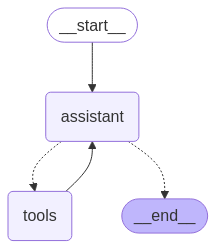

In [8]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define Nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))


# Define Edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")


react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [9]:
# messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]

messages = [HumanMessage(content="Add 3 and 4, then Multiply it by 2 and divide the result by 5")]
messages = react_graph.invoke({"messages": messages})

In [10]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4, then Multiply it by 2 and divide the result by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_fk9UAyBBytEpZ2RT7qTqXkhN)
 Call ID: call_fk9UAyBBytEpZ2RT7qTqXkhN
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_v6gemmFnpEHSwSkGxFNETPOK)
 Call ID: call_v6gemmFnpEHSwSkGxFNETPOK
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (call_E118KKWxSrSQ3faOm4vEz5Cx)
 Call ID: call_E118KKWxSrSQ3faOm4vEz5Cx
  Args:
    a: 14
    b: 5
================================= Tool Message ===============

## **🧠💪Reasoning**
- Using `"gpt-4o"` instead of `"gpt-3.5-turbo"` as the model brain can drastically enhance the resoning ability of the model

In [11]:
llm = ChatOpenAI(model="gpt-4o")

# For this ipynb we set parallel tool calling to false as math generally is done sequentially, and this time we have 3 tools that can do math
# the OpenAI model specifically defaults to parallel tool calling for efficiency, see https://python.langchain.com/docs/how_to/tool_calling_parallel/
# play around with it and see how the model behaves with math equations!
llm_with_tools_gpt_4 = llm.bind_tools(tools, parallel_tool_calls=False)


# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState): # This assistant Node works as an Agent
   return {"messages": [llm_with_tools_gpt_4.invoke([sys_msg] + state["messages"])]}
   # return {"messages": [llm_with_tools_parallel.invoke([sys_msg] + state["messages"])]


# Graph
builder = StateGraph(MessagesState)

# Define Nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))


# Define Edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")


react_graph = builder.compile()


In [12]:
messages = [HumanMessage(content="Find the average of 8 and 6")]
messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Find the average of 8 and 6
================================== Ai Message ==================================

To find the average of two numbers, you add them together and divide the sum by 2.

Let's calculate:

1. Add the numbers: \(8 + 6 = 14\).
2. Divide the sum by 2: \(\frac{14}{2} = 7\).

So, the average of 8 and 6 is 7.


## LangSmith

We can look at traces in LangSmith at https://www.langchain.com/langsmith

## **Example**


`%pip install --upgrade --quiet langchain-community`

## **Brave Search**
- https://python.langchain.com/docs/integrations/tools/brave_search/
- https://brave.com/search/api/

In [13]:
from langchain_community.tools import BraveSearch

api_key = "BSATADsn2zgJtIVoYHaMWM9Tx4k1qW8"

In [14]:
tool = BraveSearch.from_api_key(api_key=api_key, search_kwargs={"count": 1})

# or if you want to get the api key from environment variable BRAVE_SEARCH_API_KEY, and leave search_kwargs empty
# tool = BraveSearch()

# or if you want to provide just the api key, and leave search_kwargs empty
# tool = BraveSearch.from_api_key(api_key=api_key)

# or if you want to provide just the search_kwargs and read the api key from the BRAVE_SEARCH_API_KEY environment variable
# tool = BraveSearch.from_search_kwargs(search_kwargs={"count": 3})

In [15]:
obama_result = tool.invoke("obama middle name")
obama_result

'[{"title": "Obama\\u2019s Middle Name \\u2014 My Last Name \\u2014 is \\u2018Hussein.\\u2019 So?", "link": "https://www.cair.com/cair_in_the_news/obamas-middle-name-my-last-name-is-hussein-so/", "snippet": "I was. Granted, it was only a school play, and I spell my name \\u201c<strong>Hussain</strong>.\\u201d But I thought I did a pretty good job as the commander in chief, even if my wardrobe consisted of an old tweed jacket from Sears."}]'

In [16]:
import json

# Step 1: Convert string to Python list
parsed_result = json.loads(obama_result)

# Step 2: Now you can access like a list of dicts
Obama_title = parsed_result[0]["title"]
Obama_link = parsed_result[0]["link"]
Obama_snippet = parsed_result[0]["snippet"]
print("Title:", Obama_title)


Title: Obama’s Middle Name — My Last Name — is ‘Hussein.’ So?


In [17]:
import re

def clean_snippet(search_result: str) -> str:
    """
    Cleans a search result snippet by:
    - Removing HTML tags (e.g., <strong>, <br>, etc.)
    - Removing line breaks
    - Stripping extra whitespace
    """
    # Step 1: Convert string to Python list
    parsed_result = json.loads(search_result)

    # Step 2: Now you can access like a list of dicts
    title = parsed_result[0]["title"]
    link = parsed_result[0]["link"]
    snippet = parsed_result[0]["snippet"]

    cleaned_output = {}

   
    for k, v in parsed_result[0].items():
         # Remove HTML tags
        no_html = re.sub(r"<.*?>", "", v)

        # Replace multiple spaces or newlines with a single space
        cleaned = re.sub(r"\s+", " ", no_html)

        cleaned_output[k] = cleaned.strip()

    return cleaned_output


In [18]:

cleaned_output = clean_snippet(obama_result)
cleaned_output

{'title': 'Obama’s Middle Name — My Last Name — is ‘Hussein.’ So?',
 'link': 'https://www.cair.com/cair_in_the_news/obamas-middle-name-my-last-name-is-hussein-so/',
 'snippet': 'I was. Granted, it was only a school play, and I spell my name “Hussain.” But I thought I did a pretty good job as the commander in chief, even if my wardrobe consisted of an old tweed jacket from Sears.'}

In [19]:
bp_result = tool.invoke("How old is Brad Pitt?")

In [20]:
clean_snippet(bp_result)

{'title': 'Brad Pitt - Wikipedia',
 'link': 'https://en.wikipedia.org/wiki/Brad_Pitt',
 'snippet': 'William Bradley Pitt (born December 18, 1963) is an American actor and film producer. He is the recipient of various accolades, including two Academy Awards, two British Academy Film Awards, two Golden Globe Awards, and a Primetime Emmy Award. One of the most influential celebrities, Pitt appeared ...'}

## **Tools**

In [21]:
# define functions needed to create llm_with_tools
def add(a: float, b: float) -> float:
    """
    add a to b and return the result
    """
    return a + b



def multiply(a: float, b: float) -> float:
    """
    multiply a to b and return the result
    """
    return a * b


float
def divide(a: float, b: float) ->float:
    """
    divide a to b and return the result
    """
    return a / b


## **Nodes**

In [22]:
from langchain_community.tools import BraveSearch

# define serach functions needed to create llm_with_tools and Search node
api_key = "BSATADsn2zgJtIVoYHaMWM9Tx4k1qW8"
search_tool = BraveSearch.from_api_key(api_key=api_key, search_kwargs={"count": 1})


In [23]:
from langchain_openai import ChatOpenAI


llm = ChatOpenAI(model="gpt-4o")

In [24]:
from langgraph.prebuilt import ToolNode

# Define Tools
tools = [add, multiply, divide, search_tool]


# Bind tools with llm
llm_with_tools = llm.bind_tools(tools)


# define Tool node
tools = ToolNode(tools)

In [25]:
# define reasoner node

from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage


reasoner_system_message = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")


def reasoner(state: MessagesState) :
    return {'messages': [llm_with_tools.invoke([reasoner_system_message] + state['messages'])]}



## **Build the Graph**

In [36]:
# Create the grpah
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition # this is the checker for the if you got a tool back
from IPython.display import Image, display


builder = StateGraph(MessagesState)

builder.add_node("reasoner", reasoner)
builder.add_node("tools", tools)

builder.add_edge(START, "reasoner")
builder.add_conditional_edges("reasoner", tools_condition)
builder.add_edge("tools", "reasoner")


react_graph = builder.compile()

# Display the graph
# display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [37]:

messages = react_graph.invoke({"messages": HumanMessage(content="What is 2 times Brad Pitt's age?")})

In [38]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 times Brad Pitt's age?
================================== Ai Message ==================================
Tool Calls:
  brave_search (call_OV8Iiqo5QuBDSpS06zUQ3FpA)
 Call ID: call_OV8Iiqo5QuBDSpS06zUQ3FpA
  Args:
    query: Brad Pitt age 2023
================================= Tool Message =================================
Name: brave_search

[{"title": "Brad Pitt - Wikipedia", "link": "https://en.wikipedia.org/wiki/Brad_Pitt", "snippet": "William Bradley Pitt (<strong>born December 18, 1963</strong>) is an American actor and film producer. He is the recipient of various accolades, including two Academy Awards, two British Academy Film Awards, two Golden Globe Awards, and a Primetime Emmy Award. One of the most influential celebrities, Pitt appeared ..."}]
================================== Ai Message ==================================

Brad Pitt was born on December 18, 1963. As of 2023, he is 59 

## **Let's create our own custom `StateGraph`**

`%pip install yfinance`

In [39]:
import yfinance as yf

def get_stock_price(ticker: str) -> float:
    """Gets a stock price from Yahoo Finance.

    Args:
        ticker: ticker str
    """
    # """This is a tool for getting the price of a stock when passed a ticker symbol"""
    stock = yf.Ticker(ticker)
    return stock.info['previousClose']

In [40]:
get_stock_price("AAPL")

202.52

In [41]:
from typing import Annotated, TypedDict
import operator
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


class GraphState(TypedDict):
    query: str
    finance: str
    final_answer: str
    messages: Annotated[list[AnyMessage], add_messages]

# Or


class GraphState(MessagesState):
    query: str
    finance: str
    final_answer: str

In [42]:
tools = [add, multiply, divide, search_tool, get_stock_price]


tool_node = ToolNode(tools)

In [43]:
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)


def reasoner(state: GraphState)-> GraphState:
    sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.")
    user_query_msg = HumanMessage(content=state['query']) 

    all_input_messages = [  # includes all the inputs for LLM call
                          sys_msg,
                          *state["messages"], # *state["messages"] is empty initillay
                          user_query_msg
                          ] 
    
    result = llm_with_tools.invoke(all_input_messages)
    
    return {'messages': [result] }



In [44]:
builder = StateGraph(GraphState)

builder.add_node('tools', tool_node)
builder.add_node('reasoner', reasoner)

builder.add_edge(START, "reasoner")
builder.add_conditional_edges("reasoner", tools_condition)
builder.add_edge("tools", "reasoner")

react_graph = builder.compile()

# Show
# display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [45]:

response = react_graph.invoke({"query": "What is 2 times Brad Pitt's age?"})
response['messages'][-1].pretty_print()

================================== Ai Message ==================================

Brad Pitt was born on December 18, 1963. Therefore, he is currently 59 years old (as of 2023). 

2 times Brad Pitt's age (59 years) is 118.


In [46]:
response = react_graph.invoke({"query": "What is the stock price of the company that Jensen Huang is CEO of?"})
for m in response['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  brave_search (call_ZXS7icMhbBKK5hrn6ok5q4I9)
 Call ID: call_ZXS7icMhbBKK5hrn6ok5q4I9
  Args:
    query: company where Jensen Huang is CEO
================================= Tool Message =================================
Name: brave_search

[{"title": "Jensen Huang - Wikipedia", "link": "https://en.wikipedia.org/wiki/Jensen_Huang", "snippet": "Jen-Hsun &quot;Jensen&quot; Huang (Chinese: \u9ec3\u4ec1\u52f3; pinyin: Hu\u00e1ng R\u00e9nx\u016bn; Pe\u030dh-\u014de-j\u012b: N\u0302g J\u00een-hun; born February 17, 1963) is a Taiwanese and American businessman, electrical engineer, and philanthropist who is the president, co-founder, and chief executive officer (CEO) of <strong>Nvidia</strong>, the world&#x27;s ..."}]
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_FnbN3ghLMfyRmXQPZI30SGDO)
 Call ID: call_FnbN3ghLMfyRmXQPZI30SGDO
  

In [47]:
response = react_graph.invoke({"query": "What will be the price of nvidia stock if it doubles?"})
for m in response['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_ctZYXIhxt7gn9JEZBfBcg3HC)
 Call ID: call_ctZYXIhxt7gn9JEZBfBcg3HC
  Args:
    ticker: NVDA
================================= Tool Message =================================
Name: get_stock_price

110.71
================================== Ai Message ==================================
Tool Calls:
  multiply (call_hI3rkwok85NIEjo9btHJ9ByF)
 Call ID: call_hI3rkwok85NIEjo9btHJ9ByF
  Args:
    a: 110.71
    b: 2
================================= Tool Message =================================
Name: multiply

221.42
================================== Ai Message ==================================

If the price of NVIDIA stock doubles, it will be $221.42.


## ✅ Key Differences Between calling a function as a Node and a Tool

| Feature                           | Function Calling as a Node                 | Tool (`@tool`) Function                     |
|-----------------------------------|--------------------------------------------|---------------------------------------------|
| **Invoked by...**                 | You (via LangGraph edges)                  | The LLM (via `tool_calls`)                  |
| **Input format**                  | `state: State`                             | Explicit arguments (e.g., `a: int`)         |
| **Purpose**                       | Part of graph flow                         | Model-usable external function              |
| **Tool metadata?**                | ❌ No                                       | ✅ Yes (name, description)                   |
| **Automatically selected by LLM?**| ❌ No                                       | ✅ Yes                                       |
